In [2]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [3]:
PATH_CODED_IDS_TRAIN = "data/users/coded_ids_labels_train.csv"

In [4]:
train_users = pd.read_csv(PATH_CODED_IDS_TRAIN)
print("number of elements in train : " , len(train_users))

number of elements in train :  686


In [5]:
spam_counter = 0
legit_counter = 0
train_len = len(train_users)
for i in train_users[:]['label']:
    if(i == 1):
        spam_counter += 1
    else:
        legit_counter += 1
print(spam_counter)
print(legit_counter)

118
568


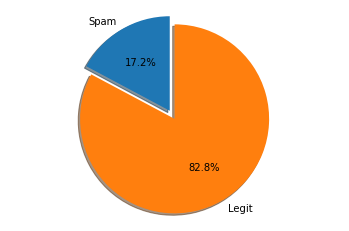

In [6]:
labels = 'Spam', 'Legit'
pie_sizes = []
pie_sizes.append(100 / train_len * spam_counter)
pie_sizes.append(100 / train_len * legit_counter)
fig1, ax1 = plt.subplots()
ax1.pie(pie_sizes, explode=(0.1, 0), labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()